# Machine Learning for Fire/Smoke Detection

This notebook used the Smoke Detection Dataset [1] to test the performance of three linear classifiers, that is;
- Support Vector Classifier
- Logistic Regression with Cross Validation
- Ridge Regression with Cross Validation

[1] https://www.kaggle.com/datasets/deepcontractor/smoke-detection-dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from datetime import datetime

from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

mpl.rcParams['font.family'] = 'Bahnschrift'
mpl.rcParams['font.size'] = 14
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read data file

df1 = pd.read_csv(r'C:\Users\opio\Desktop\Data Science\python_projects\ML\classification\smoke_detection_iot.csv')
df1.head()

,Unnamed: 0,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0,0
1,1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,1,0
2,2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,2,0
3,3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,3,0
4,4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,4,0


## Data Cleaning

In [3]:
# There were no null values when I checked with
df1.info()

# Drop unmaed column and the time column
df = df1.drop(['Unnamed: 0', 'UTC'], axis=1)

# Change column names to remove brackets and units
new_cols = ['temperature', 'humidity', 'TVOC', 'eCO2', 'hydgrogen', 'ethanol', 'pressure',
           'pm10', 'pm2.5', 'NC0.5', 'NC10', 'NC2.5', 'samples', 'fire_alarm']

df.columns = new_cols
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62630 entries, 0 to 62629
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      62630 non-null  int64  
 1   UTC             62630 non-null  int64  
 2   Temperature[C]  62630 non-null  float64
 3   Humidity[%]     62630 non-null  float64
 4   TVOC[ppb]       62630 non-null  int64  
 5   eCO2[ppm]       62630 non-null  int64  
 6   Raw H2          62630 non-null  int64  
 7   Raw Ethanol     62630 non-null  int64  
 8   Pressure[hPa]   62630 non-null  float64
 9   PM1.0           62630 non-null  float64
 10  PM2.5           62630 non-null  float64
 11  NC0.5           62630 non-null  float64
 12  NC1.0           62630 non-null  float64
 13  NC2.5           62630 non-null  float64
 14  CNT             62630 non-null  int64  
 15  Fire Alarm      62630 non-null  int64  
dtypes: float64(8), int64(8)
memory usage: 7.6 MB


,temperature,humidity,TVOC,eCO2,hydgrogen,ethanol,pressure,pm10,pm2.5,NC0.5,NC10,NC2.5,samples,fire_alarm
0,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0,0
1,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,1,0
2,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,2,0
3,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,3,0
4,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,4,0


## Exploratory Data Analysis

In [4]:
# Get descriptive statistics

df.describe().round(1)

,temperature,humidity,TVOC,eCO2,hydgrogen,ethanol,pressure,pm10,pm2.5,NC0.5,NC10,NC2.5,samples,fire_alarm
count,62630.0,62630.0,62630.0,62630.0,62630.0,62630.0,62630.0,62630.0,62630.0,62630.0,62630.0,62630.0,62630.0,62630.0
mean,16.0,48.5,1942.1,670.0,12942.5,19754.3,938.6,100.6,184.5,491.5,203.6,80.0,10511.4,0.7
std,14.4,8.9,7811.6,1905.9,272.5,609.5,1.3,922.5,1976.3,4265.7,2214.7,1083.4,7597.9,0.5
min,-22.0,10.7,0.0,400.0,10668.0,15317.0,930.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,11.0,47.5,130.0,400.0,12830.0,19435.0,938.7,1.3,1.3,8.8,1.4,0.0,3625.2,0.0
50%,20.1,50.2,981.0,400.0,12924.0,19501.0,938.8,1.8,1.9,12.4,1.9,0.0,9336.0,1.0
75%,25.4,53.2,1189.0,438.0,13109.0,20078.0,939.4,2.1,2.2,14.4,2.2,0.1,17164.8,1.0
max,59.9,75.2,60000.0,60000.0,13803.0,21410.0,939.9,14333.7,45432.3,61482.0,51914.7,30026.4,24993.0,1.0


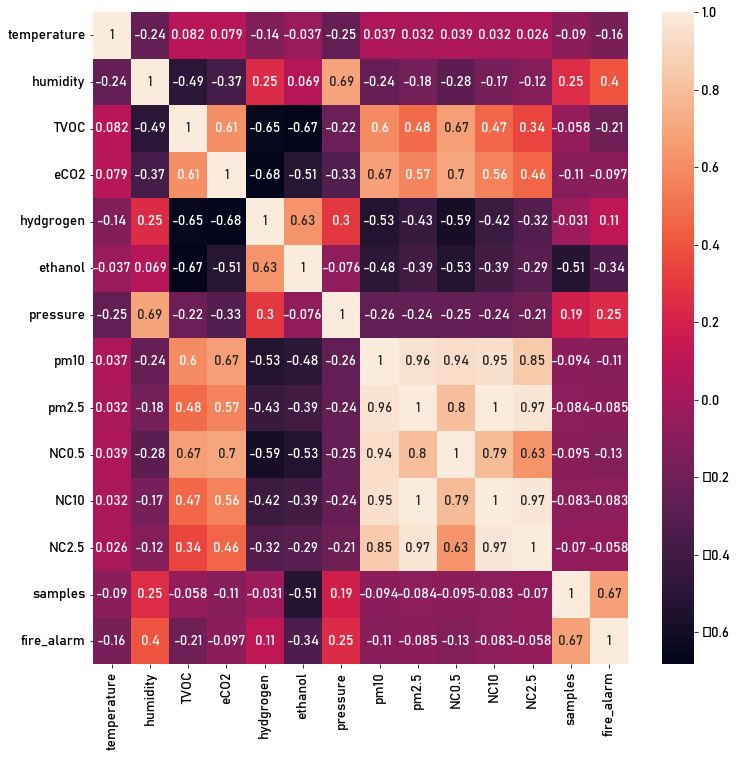

In [5]:
# Check for data correlation. This information might even be useful when doing feature selection later on

correlation = df.corr()

fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(correlation, annot=True)
plt.show()

## Data Preprocessing and Feature Selection

In [6]:
x = df.drop(['fire_alarm'], axis=1)
y = df['fire_alarm']

In [7]:
# Scale the data

scaler = preprocessing.MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)

In [8]:
# Split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [9]:
# Do feature selection using the ANOVA F-value and associated P-value

classifier = f_classif(X_train, y_train)
classifier

(array([ 1202.27532178,  8673.3663625 ,  2261.5567767 ,   448.13771083,
          576.19289605,  5396.8227958 ,  3017.99425649,   567.30841663,
          324.76860761,   774.55082368,   308.15210587,   144.04541378,
        36552.63241111]),
 array([6.49309617e-260, 0.00000000e+000, 0.00000000e+000, 5.74941203e-099,
        1.66015355e-126, 0.00000000e+000, 0.00000000e+000, 1.34236409e-124,
        2.41968806e-072, 5.46538857e-169, 9.49245744e-069, 3.91424132e-033,
        0.00000000e+000]))

In [10]:
# All features will be retained since they have a p-value < 0.05 (95% confidence interval)
# The values are very small because I used scaled data, but I also tested it with the original data and the result was similar

## Perform Classification

In [11]:
# Support Vector Classifier
model_svc = LinearSVC()
model_svc = model_svc.fit(X_train, y_train)
y_pred_svc = model_svc.predict(X_test)

#Logitic Regression with cross validation
model_lrcv = linear_model.LogisticRegressionCV()
model_lrcv = model_lrcv.fit(X_train, y_train)
y_pred_lrcv = model_lrcv.predict(X_test)

#Ridge Regression with cross validation
model_ridge = linear_model.RidgeClassifierCV()
model_ridge = model_ridge.fit(X_train, y_train)
y_pred_ridge = model_ridge.predict(X_test)

## Perform Evaluation

In [12]:
# Test Accuracy

print('Accuracy of Support Vector Classifier is', (accuracy_score(y_test, y_pred_svc)).round(2))
print('Accuracy of Logistic Regression with CV is', (accuracy_score(y_test, y_pred_lrcv)).round(2))
print('Accuracy of Ridge Regression with CV is', (accuracy_score(y_test, y_pred_ridge)).round(2))

Accuracy of Support Vector Classifier is 0.98
Accuracy of Logistic Regression with CV is 1.0
Accuracy of Ridge Regression with CV is 0.92


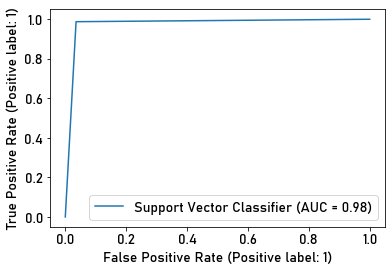

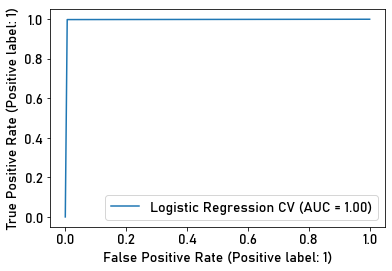

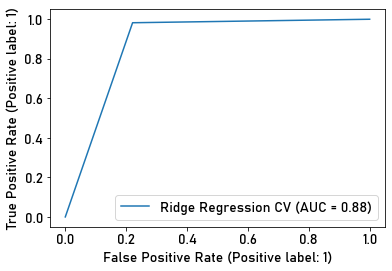

In [13]:
# Plot ROC_AUC_Curve

RocCurveDisplay.from_predictions(y_test, y_pred_svc, name='Support Vector Classifier')
RocCurveDisplay.from_predictions(y_test, y_pred_lrcv, name='Logistic Regression CV')
RocCurveDisplay.from_predictions(y_test, y_pred_ridge, name='Ridge Regression CV')
plt.show()

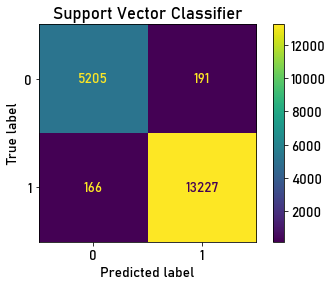

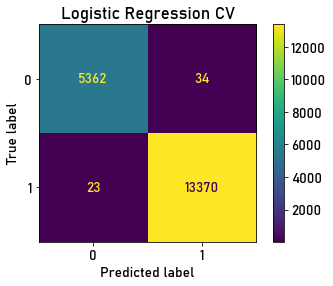

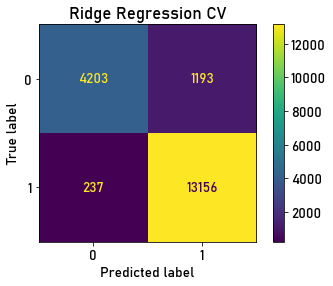

In [14]:
# Plot Confusion Matrices

cm_svc = confusion_matrix(y_test, y_pred_svc)
cm_lrcv = confusion_matrix(y_test, y_pred_lrcv)
cm_ridge = confusion_matrix(y_test, y_pred_ridge)

d_svc = ConfusionMatrixDisplay(cm_svc)
d_lrcv = ConfusionMatrixDisplay(cm_lrcv)
d_ridge = ConfusionMatrixDisplay(cm_ridge)

d_svc.plot()
plt.title('Support Vector Classifier')

d_lrcv.plot()
plt.title('Logistic Regression CV')

d_ridge.plot()
plt.title('Ridge Regression CV')

plt.show()

In [15]:
print('Support Vector Classifier')
print('---'*9)
print('Sensitivity or True Positive Rate = TP/(TP+FN) =', 13327/(13327+161))
print('Specificity or True Negative Rate = TN/(TN+FP) =', 5098/(5098+203))
print('==='*30)
print('Logistic Regression CV')
print('---'*9)
print('Sensitivity or True Positive Rate = TP/(TP+FN) =', 13470/(13470+18))
print('Specificity or True Negative Rate = TN/(TN+FP) =', 5265/(5265+36))
print('==='*30)
print('Ridge Regression CV')
print('---'*9)
print('Sensitivity or True Positive Rate = TP/(TP+FN) =', 13268/(13268+220))
print('Specificity or True Negative Rate = TN/(TN+FP) =', 4177/(4177+1124))
print('======= END =======')

Support Vector Classifier
---------------------------
Sensitivity or True Positive Rate = TP/(TP+FN) = 0.9880634638196916
Specificity or True Negative Rate = TN/(TN+FP) = 0.9617053386153556
Logistic Regression CV
---------------------------
Sensitivity or True Positive Rate = TP/(TP+FN) = 0.9986654804270463
Specificity or True Negative Rate = TN/(TN+FP) = 0.9932088285229203
Ridge Regression CV
---------------------------
Sensitivity or True Positive Rate = TP/(TP+FN) = 0.9836892052194544
Specificity or True Negative Rate = TN/(TN+FP) = 0.7879645349933975
======= END =======


## CONCLUSION

### Logistic Regression with cross validation performed best of all the classifiers. It had accuracy of just under 100%.